In [1]:
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle as pkl

## Calibration Results

In [2]:
build_path = Path('chiir-2020') / 'calibration-results'
pattern = re.compile('calibration_table.*.txt')
calibration_results = [x for x in build_path.iterdir() if x.is_file() and re.match(pattern, x.name)]

In [3]:
len(calibration_results)

60

In [4]:
results = []
columns = None
for p in calibration_results:
    with open(p, 'r') as f:
        try:
            columns, result = [line.strip().split(',') for line in f.readlines()]
        except Exception as e:
            print(p)
            print(e)
    model, dataset, *stats = p.name.split('-')
    stats = '-'.join(stats).replace('.txt', '')
    result.append(stats)
    results.append(result)

In [5]:
calibration_table = pd.DataFrame.from_records(results, columns=[*columns, 'Opt.'])

In [6]:
calibration_table.head()

,Data,Pref,Obs,Item Pop,User Act,I-I Sim,U-U Sim,Opt.
0,az_music_5core,IBP,Pop,4.170343986918846/0.031916732424400705,0.1435233760492466/0.007873720438752663,0.01642133200008846/0.0036170487726879296,0.019753442774945295/0.0016272246734081901,avg_loss
1,az_music_5core,IBP,Pop,4.156789524896516/0.3789084375317254,5.032267437694443/0.07878846869083199,0.10449470293720005/0.020917927711702873,1.7826951836549565/0.25971776011405157,icorr
2,az_music_5core,IBP,Pop,0.8422424724567701/0.016712703217112882,0.8587954467836015/0.04273108900199218,0.08438119126231795/0.002082597779909971,0.053602666034914745/0.006141120170277056,item-pop
3,az_music_5core,IBP,Pop,3.787636472547978/0.018585540565210237,0.2588024145591909/0.006436585170651757,0.04246138445239165/0.001984096831062325,0.005683621381841144/0.0004496147098235027,ucorr
4,az_music_5core,IBP,Pop,8.023227619990164/0.0346683448566451,0.036389153740852755/0.003091644621644008,0.07204694087789418/0.0029213326358666905,0.060182425845559995/0.010126642239657004,user-act


Round numbers

In [7]:
trunc_num = lambda x: round(float(x.split('/')[0]), 3)

In [8]:
for col in ['Item Pop', 'User Act', 'I-I Sim', 'U-U Sim']:
    calibration_table[col] = calibration_table[col].map(trunc_num)

Rename columns

In [9]:
dataname = dict(az_music_5core='AZM5', 
                ml_1m='ML1M', 
                steam_video_game='STMV1')
statsname = {'icorr': 'I-I Sim', 'ucorr': 'U-U Sim', 
             'item-pop': 'Item Pop', 'user-act': 'User Act', 
             'avg_loss': 'Avg. Loss'}
calibration_table['Data'] = calibration_table['Data'].map(dataname.get)
calibration_table['Opt.'] = calibration_table['Opt.'].map(statsname.get)

In [10]:
calibration_table.groupby(['Opt.', 'Data', 'Pref', 'Obs']).sum().head()

Item Pop  User Act  I-I Sim  U-U Sim
Opt.      Data Pref Obs                                       
Avg. Loss AZM5 IBP  Pop      4.170     0.144    0.016    0.020
                    Unif     4.639     0.100    0.024    0.020
               LDA  Pop      0.485     0.045    0.035    0.008
                    Unif     1.029     0.114    0.015    0.002
          ML1M IBP  Pop      1.793     0.388    0.200    0.170

In [11]:
calibration_table.groupby(['Opt.', 'Data', 'Pref', 'Obs']).mean().head()

Item Pop  User Act  I-I Sim  U-U Sim
Opt.      Data Pref Obs                                       
Avg. Loss AZM5 IBP  Pop      4.170     0.144    0.016    0.020
                    Unif     4.639     0.100    0.024    0.020
               LDA  Pop      0.485     0.045    0.035    0.008
                    Unif     1.029     0.114    0.015    0.002
          ML1M IBP  Pop      1.793     0.388    0.200    0.170

In [12]:
calibration_table['Model'] = calibration_table['Pref'] + '-' + calibration_table['Obs']

In [13]:
calibration_table = calibration_table[['Data', 'Opt.', 'Model', 'I-I Sim', 'Item Pop', 'U-U Sim', 'User Act']].copy()

In [14]:
calibration_table.head()

,Data,Opt.,Model,I-I Sim,Item Pop,U-U Sim,User Act
0,AZM5,Avg. Loss,IBP-Pop,0.016,4.170,0.020,0.144
1,AZM5,I-I Sim,IBP-Pop,0.104,4.157,1.783,5.032
2,AZM5,Item Pop,IBP-Pop,0.084,0.842,0.054,0.859
3,AZM5,U-U Sim,IBP-Pop,0.042,3.788,0.006,0.259
4,AZM5,User Act,IBP-Pop,0.072,8.023,0.060,0.036


In [15]:
calibration_table['Data'] = pd.Categorical(calibration_table['Data'], 
                                           categories=['ML1M', 'AZM5', 'STMV1'], 
                                           ordered=True)
calibration_table['Opt.'] = pd.Categorical(calibration_table['Opt.'], 
                                           categories=['Avg. Loss', 'I-I Sim', 'Item Pop', 'U-U Sim', 'User Act'], 
                                           ordered=True)
calibration_table['Model'] = pd.Categorical(calibration_table['Model'], 
                                            categories=['IBP-Unif', 'IBP-Pop', 'LDA-Unif', 'LDA-Pop'], 
                                            ordered=True)

In [16]:
calibration_table = calibration_table.sort_values(['Data', 'Opt.', 'Model'])
calibration_table

,Data,Opt.,Model,I-I Sim,Item Pop,U-U Sim,User Act
20,ML1M,Avg. Loss,IBP-Unif,0.170,0.973,0.227,0.373
5,ML1M,Avg. Loss,IBP-Pop,0.200,1.793,0.170,0.388
50,ML1M,Avg. Loss,LDA-Unif,0.137,0.737,0.082,0.669
35,ML1M,Avg. Loss,LDA-Pop,0.050,2.063,0.291,1.084
21,ML1M,I-I Sim,IBP-Unif,0.218,0.846,0.185,0.477
6,ML1M,I-I Sim,IBP-Pop,0.081,1.184,0.294,0.361
51,ML1M,I-I Sim,LDA-Unif,0.011,0.460,0.355,0.397
36,ML1M,I-I Sim,LDA-Pop,0.002,0.490,0.163,0.478
22,ML1M,Item Pop,IBP-Unif,1.385,0.791,1.132,4.022
7,ML1M,Item Pop,IBP-Pop,1.064,0.795,1.322,3.958


In [17]:
calibration_table.to_csv('build/chiir-2020/calibration-results/calibration_table.tsv', sep='\t', index=False)

## Simulation Results

In [18]:
build_path = Path('chiir-2020') / 'simulation-results'
pattern = re.compile('simulate.*pkl')
simulation_results = [x for x in build_path.iterdir() if x.is_file() and re.match(pattern, x.name)]

In [19]:
len(simulation_results)

12

In [20]:
simulation_results

[PosixPath('build/chiir-2020/simulation-results/simulate_ibp_pop_csr-az_music_5core.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_ibp_pop_csr-ml_1m.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_ibp_pop_csr-steam_video_game.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_ibp_unif_csr-az_music_5core.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_ibp_unif_csr-ml_1m.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_ibp_unif_csr-steam_video_game.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_lda_pop_csr-az_music_5core.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_lda_pop_csr-ml_1m.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_lda_pop_csr-steam_video_game.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_lda_unif_csr-az_music_5core.pkl'),
 PosixPath('build/chiir-2020/simulation-results/simulate_lda_unif_csr-ml_1m.pkl'),
 PosixPath('build/chiir-

In [21]:
results = []
for p in simulation_results:
    with open(p, 'rb') as f:
        result = pkl.load(f)
        nalgos = len(result['algorithm'].unique())
        nruns = int(len(result) / nalgos)
        result['no'] = np.repeat(range(nruns), nalgos)
        model, dataset = p.name.split('-')
        dataset = dataset.replace('.pkl', '')
        _, pref_name, obs_name, _ = model.split('_')
        print(f'Loading simulation results -- Model {pref_name}-{obs_name}, ' 
              f'Data {dataset}, {nalgos} algorithms, and {nruns} runs')
        result['generator'] = pref_name
        result['sampler'] = obs_name
        result['stats_to_tune'] = 'Relative Loss'
        result['dataset'] = dataset
        results.append(result)
results = pd.concat(results, axis=0, ignore_index=True)

Loading simulation results -- Model ibp-pop, Data az_music_5core, 3 algorithms, and 100 runs
Loading simulation results -- Model ibp-pop, Data ml_1m, 3 algorithms, and 100 runs
Loading simulation results -- Model ibp-pop, Data steam_video_game, 3 algorithms, and 100 runs
Loading simulation results -- Model ibp-unif, Data az_music_5core, 3 algorithms, and 100 runs
Loading simulation results -- Model ibp-unif, Data ml_1m, 3 algorithms, and 100 runs
Loading simulation results -- Model ibp-unif, Data steam_video_game, 3 algorithms, and 100 runs
Loading simulation results -- Model lda-pop, Data az_music_5core, 3 algorithms, and 100 runs
Loading simulation results -- Model lda-pop, Data ml_1m, 3 algorithms, and 100 runs
Loading simulation results -- Model lda-pop, Data steam_video_game, 3 algorithms, and 100 runs
Loading simulation results -- Model lda-unif, Data az_music_5core, 3 algorithms, and 100 runs
Loading simulation results -- Model lda-unif, Data ml_1m, 3 algorithms, and 100 runs
Lo

In [22]:
np.all(results.groupby(['dataset', 'stats_to_tune', 'generator', 'sampler', 'algorithm']).count().values == 100)

True

In [23]:
results.head()

,algorithm,precision_obs,recall_obs,recip_rank_obs,ndcg_obs,precision_pref,recall_pref,recip_rank_pref,ndcg_pref,no,generator,sampler,stats_to_tune,dataset
0,Oracle,0.011741,0.223439,0.033210,0.064194,1.000000,0.116278,1.000000,0.215834,0,ibp,pop,Relative Loss,az_music_5core
1,Popular,0.003277,0.074104,0.020991,0.026199,0.098091,0.011338,0.307952,0.022758,0,ibp,pop,Relative Loss,az_music_5core
2,Random,0.000130,0.002577,0.000439,0.000686,0.016398,0.001899,0.064286,0.003518,0,ibp,pop,Relative Loss,az_music_5core
3,Oracle,0.013037,0.228881,0.034714,0.066369,1.000000,0.116516,1.000000,0.216151,1,ibp,pop,Relative Loss,az_music_5core
4,Popular,0.003526,0.078805,0.022896,0.028713,0.099347,0.011500,0.310087,0.023035,1,ibp,pop,Relative Loss,az_music_5core


In [24]:
def extract_result(sims_results, metric='precision', stats_to_tune=None, dataset=None):
    """Extracts simulation results for a given evaluation metric, tunning statistic and dataset"""
    obs_label = ''.join([metric, '_obs'])
    pref_label = ''.join([metric, '_pref'])
    result = sims_results[['algorithm', obs_label, pref_label, 'no', 'generator', 'sampler', 'stats_to_tune', 'dataset']]
    if stats_to_tune:
        result = result[result['stats_to_tune'] == stats_to_tune]
    if dataset:
        result = result[result['dataset'] == dataset]
    result = result.rename(columns={obs_label: 'observation', pref_label: 'preference'})
    result['error'] = result['observation'] - result['preference']
    return result

Renaming

In [25]:
results['sampler'] = results['sampler'].str.capitalize()
results['generator'] = results['generator'].str.upper()
dataname = dict(az_music_5core='AZM5', ml_1m='ML1M', steam_video_game='STMV1')
results['dataset'] = results['dataset'].map(dataname.get)
results.head()

,algorithm,precision_obs,recall_obs,recip_rank_obs,ndcg_obs,precision_pref,recall_pref,recip_rank_pref,ndcg_pref,no,generator,sampler,stats_to_tune,dataset
0,Oracle,0.011741,0.223439,0.033210,0.064194,1.000000,0.116278,1.000000,0.215834,0,IBP,Pop,Relative Loss,AZM5
1,Popular,0.003277,0.074104,0.020991,0.026199,0.098091,0.011338,0.307952,0.022758,0,IBP,Pop,Relative Loss,AZM5
2,Random,0.000130,0.002577,0.000439,0.000686,0.016398,0.001899,0.064286,0.003518,0,IBP,Pop,Relative Loss,AZM5
3,Oracle,0.013037,0.228881,0.034714,0.066369,1.000000,0.116516,1.000000,0.216151,1,IBP,Pop,Relative Loss,AZM5
4,Popular,0.003526,0.078805,0.022896,0.028713,0.099347,0.011500,0.310087,0.023035,1,IBP,Pop,Relative Loss,AZM5


In [26]:
def get_data(results, stats_data=((None, 'ML1M'), (None, 'AZM5'), (None, 'STMV1'))):
    data_result = []
    for stats, d in stats_data:
        for metric in ['precision', 'recall', 'recip_rank', 'ndcg']:
            result = extract_result(results, metric=metric, stats_to_tune=stats, dataset=d).drop(['stats_to_tune'], axis=1)
            if result.empty: continue
            result['metric'] = metric
            result['model'] = result[['generator', 'sampler']].apply(lambda x: '-'.join([x[0], x[1]]), axis=1)
            data_result.append(result)
    return pd.concat(data_result, ignore_index=True)

In [27]:
best_fit_results = get_data(results)
best_fit_results.head()

,algorithm,observation,preference,no,generator,sampler,dataset,error,metric,model
0,Oracle,0.194798,1.000000,0,IBP,Pop,ML1M,-0.805202,precision,IBP-Pop
1,Popular,0.209540,0.994735,0,IBP,Pop,ML1M,-0.785195,precision,IBP-Pop
2,Random,0.011632,0.142493,0,IBP,Pop,ML1M,-0.130861,precision,IBP-Pop
3,Oracle,0.195623,1.000000,1,IBP,Pop,ML1M,-0.804377,precision,IBP-Pop
4,Popular,0.209573,0.994682,1,IBP,Pop,ML1M,-0.785109,precision,IBP-Pop


In [28]:
metric_name = dict(precision='Precision', recall='Recall', recip_rank='MRR', ndcg='NDCG')
best_fit_results['metric'] = best_fit_results['metric'].map(metric_name.get)
best_fit_results.rename(columns={'generator': 'Pref', 'sampler': 'Obs', 'error': 'Error', 
                                 'algorithm': 'Algorithm', 'dataset': 'Data'}, inplace=True)
best_fit_results['Obs-Data'] = best_fit_results[['Obs', 'Data']].apply(lambda x: '-'.join([x[0], x[1]]), axis=1)
best_fit_results.head()

,Algorithm,observation,preference,no,Pref,Obs,Data,Error,metric,model,Obs-Data
0,Oracle,0.194798,1.000000,0,IBP,Pop,ML1M,-0.805202,Precision,IBP-Pop,Pop-ML1M
1,Popular,0.209540,0.994735,0,IBP,Pop,ML1M,-0.785195,Precision,IBP-Pop,Pop-ML1M
2,Random,0.011632,0.142493,0,IBP,Pop,ML1M,-0.130861,Precision,IBP-Pop,Pop-ML1M
3,Oracle,0.195623,1.000000,1,IBP,Pop,ML1M,-0.804377,Precision,IBP-Pop,Pop-ML1M
4,Popular,0.209573,0.994682,1,IBP,Pop,ML1M,-0.785109,Precision,IBP-Pop,Pop-ML1M


### Point plots

In [29]:
def point_plot_results(metric, style='talk', height=2.4, aspect=1.7):
    data2plot = best_fit_results[best_fit_results['metric'] == metric]
    data2plot = data2plot.rename(columns={'Error': f'{metric}-Error'})

    with sns.plotting_context(style, 1):
        g = sns.FacetGrid(data2plot, col='Obs', row='Pref', 
                          height=height, aspect=aspect, 
                          margin_titles=True, sharey=True, sharex=True,
                          col_order=['Unif', 'Pop'], 
                          row_order=['IBP', 'LDA'])
        g = g.map(plt.axhline)
        g = (g.map_dataframe(sns.pointplot, 'Algorithm', f'{metric}-Error', hue='Data',
                             hue_order=['ML1M', 'AZM5', 'STMV1'],
                             order=['Oracle', 'Popular', 'Random'],
                             palette='husl',
                             join=False,
                             dodge=0.5,
                             markers=["o", "x", "*"],
                             ci=95,
                             capsize=.2)
             .add_legend().set_titles(col_template="{col_name}"))
        g.savefig(f'build/chiir-2020/simulation-results/figures/{metric.lower()}-error-point-height{height}-aspect{aspect}.pdf')

Precision

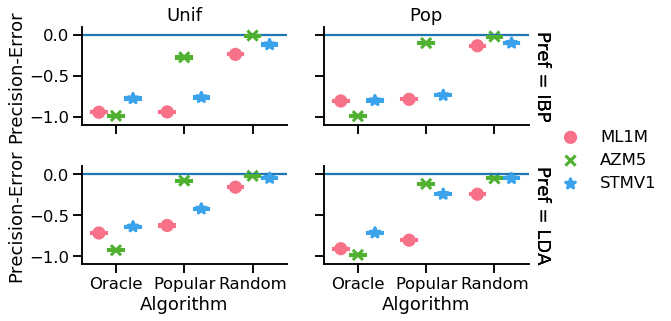

In [30]:
point_plot_results(metric='Precision', height=2.4, aspect=1.7)

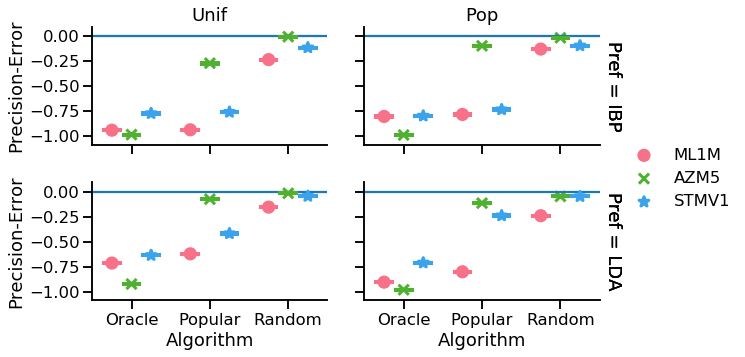

In [31]:
point_plot_results(metric='Precision', height=2.65, aspect=1.7)

Recall

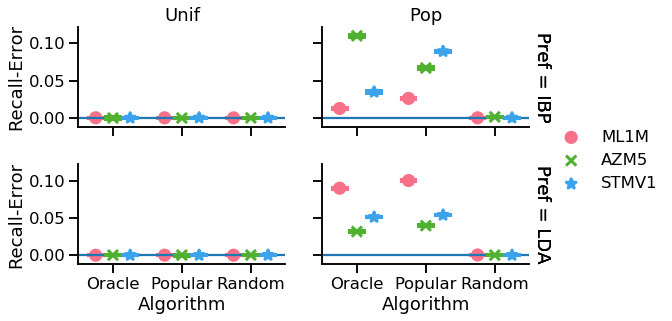

In [32]:
point_plot_results(metric='Recall', height=2.4, aspect=1.7)

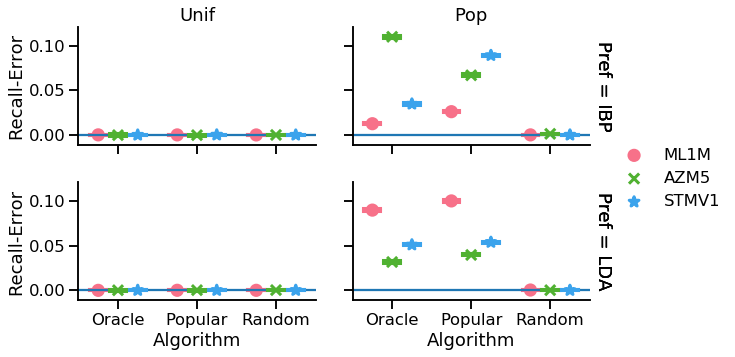

In [33]:
point_plot_results(metric='Recall', height=2.65, aspect=1.7)

MRR

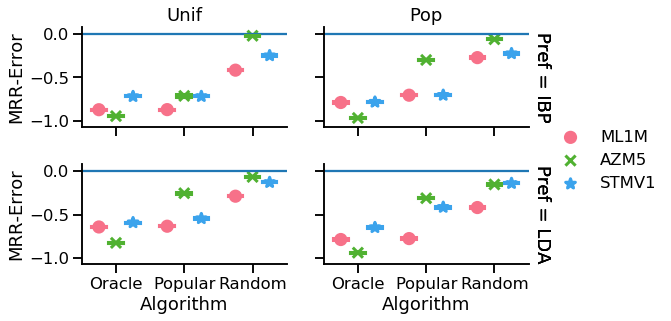

In [34]:
point_plot_results(metric='MRR', height=2.4, aspect=1.7)

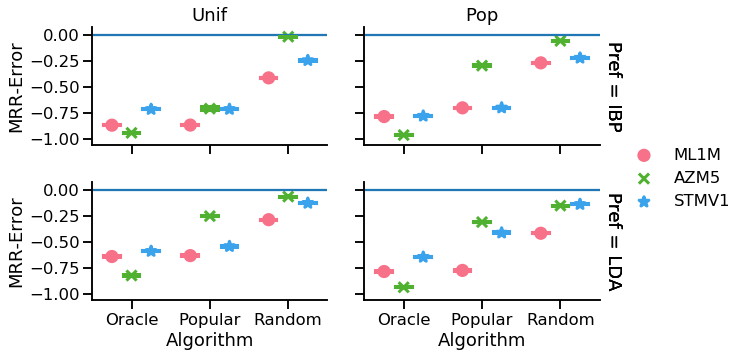

In [35]:
point_plot_results(metric='MRR', height=2.65, aspect=1.7)

nDCG

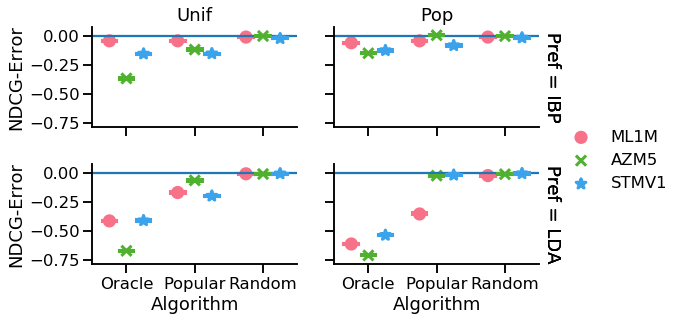

In [36]:
point_plot_results(metric='NDCG', height=2.4, aspect=1.7)

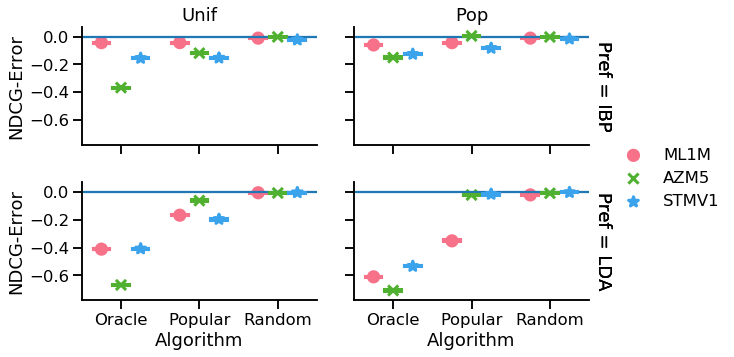

In [37]:
point_plot_results(metric='NDCG', height=2.65, aspect=1.7)

## Ranking Algorithms

In [38]:
def rank_algos(data, algo_pair=('Oracle', 'Popular')):
    data_pivot = data.drop(['Error', 'stats_to_tune'], axis=1, errors='ignore').pivot_table(index=['no', 'Pref', 'Obs', 'Data'], columns='Algorithm')
    algo1, algo2 = algo_pair
    obs_rank = (data_pivot['observation'][algo1] >= data_pivot['observation'][algo2])
    obs_rank = obs_rank.groupby(level=['Pref', 'Obs', 'Data']).sum().rename('observation')
    pref_rank = (data_pivot['preference'][algo1] >= data_pivot['preference'][algo2])
    pref_rank = pref_rank.groupby(level=['Pref', 'Obs', 'Data']).sum().rename('preference')
    return pd.concat([obs_rank, pref_rank], axis=1).stack().rename('count').reset_index().rename(columns={'level_3': 'data_model'})

In [39]:
def rank_algorithms(data):
    rank_results = []
    for metric in ['Precision', 'Recall', 'MRR', 'NDCG']:
        res = rank_algos(data[data['metric']==metric].drop(['metric', 'model'], axis=1))
        res['metric'] = metric
        rank_results.append(res)
    return pd.concat(rank_results, ignore_index=True)

In [40]:
rank_results = rank_algorithms(best_fit_results)
rank_results = rank_results[rank_results['data_model'] == 'observation']  # comment this line for preference and observation
rank_results['count'] = rank_results['count'].map(lambda x: ''.join([str(int(x)), '%']))
rank_results.pivot_table(index=['Data', 'Pref', 'Obs', 'data_model'], 
                         columns='metric', values='count', aggfunc='sum').unstack()[['Precision', 'Recall', 'MRR', 'NDCG']]

metric            Precision      Recall         MRR        NDCG
data_model      observation observation observation observation
Data  Pref Obs                                                 
AZM5  IBP  Pop         100%        100%         99%        100%
           Unif        100%        100%        100%        100%
      LDA  Pop         100%        100%        100%        100%
           Unif        100%        100%        100%        100%
ML1M  IBP  Pop           0%          0%          0%          0%
           Unif         87%         58%         47%         65%
      LDA  Pop         100%        100%         89%        100%
           Unif        100%        100%        100%        100%
STMV1 IBP  Pop         100%          5%          0%         85%
           Unif        100%        100%         86%        100%
      LDA  Pop         100%        100%        100%        100%
           Unif        100%        100%        100%        100%